# Dependencies and notebook settings

In [18]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.stats import diagnostic
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
plt.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 250

# Descriptive analysis of the dataset - S&P 500 stock data 

## Shallow data wrangling 

In [32]:
df = pd.read_csv("../dataset/spx.csv", parse_dates=["Date"], 
                 names=["Date", "Open", "High", "Low", "Close", "Volume"], 
                 header=0, index_col = "Date")
df = df[df.index < "2020-10-01"]
display(df.head(5))
df.info()

,Open,High,Low,Close,Volume
Date,,,,,
1990-05-01,330.80,332.83,330.80,332.25,82788889
1990-05-02,332.25,334.48,332.15,334.48,78672222
1990-05-03,334.48,337.02,334.47,335.57,80866667
1990-05-04,335.58,338.46,335.17,338.39,78083333
1990-05-07,338.39,341.07,338.11,340.53,73755556


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7665 entries, 1990-05-01 to 2020-09-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    7665 non-null   float64
 1   High    7665 non-null   float64
 2   Low     7665 non-null   float64
 3   Close   7665 non-null   float64
 4   Volume  7665 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 359.3 KB


In [33]:
df["rr"] = (np.log(df.Close) - np.log(df.Close.shift(1)))*100
df.dropna(inplace=True)

In [34]:
df.head()

,Open,High,Low,Close,Volume,rr
Date,,,,,,
1990-05-02,332.25,334.48,332.15,334.48,78672222,0.668939
1990-05-03,334.48,337.02,334.47,335.57,80866667,0.325349
1990-05-04,335.58,338.46,335.17,338.39,78083333,0.836850
1990-05-07,338.39,341.07,338.11,340.53,73755556,0.630415
1990-05-08,340.53,342.03,340.17,342.01,80127778,0.433675


##  Statistical exploratory data analysis - window by window

I have defined following training, validation and testing periods (based on best practices in VaR modeling). Each training period lasts 3 trading years (3* 252 days), each validation and testing period lasts 1 trading year (252 days).
* Econometrics
    * training - 2016-09-29 : 2019-10-01
    * testing - 2019-10-02	: 2020-09-30
* Machine learning
    * 1 training and validation
        * 2006-01-12 : 2009-01-14
        * 2009-01-15 : 2010-01-13
    * 2 training and validation
        * 2008-01-15 : 2011-01-12 
        * 2011-01-13 : 2012-01-12 
    * 3 training and validation
        * 2014-01-13 : 2017-01-11
        * 2017-01-12 : 2018-01-11
    * final training and testing
        * training - 2016-09-29 : 2019-10-01
        * testing - 2019-10-02	: 2020-09-30

### Econometrics training and testing period & Machine Learning `final` training and testing period

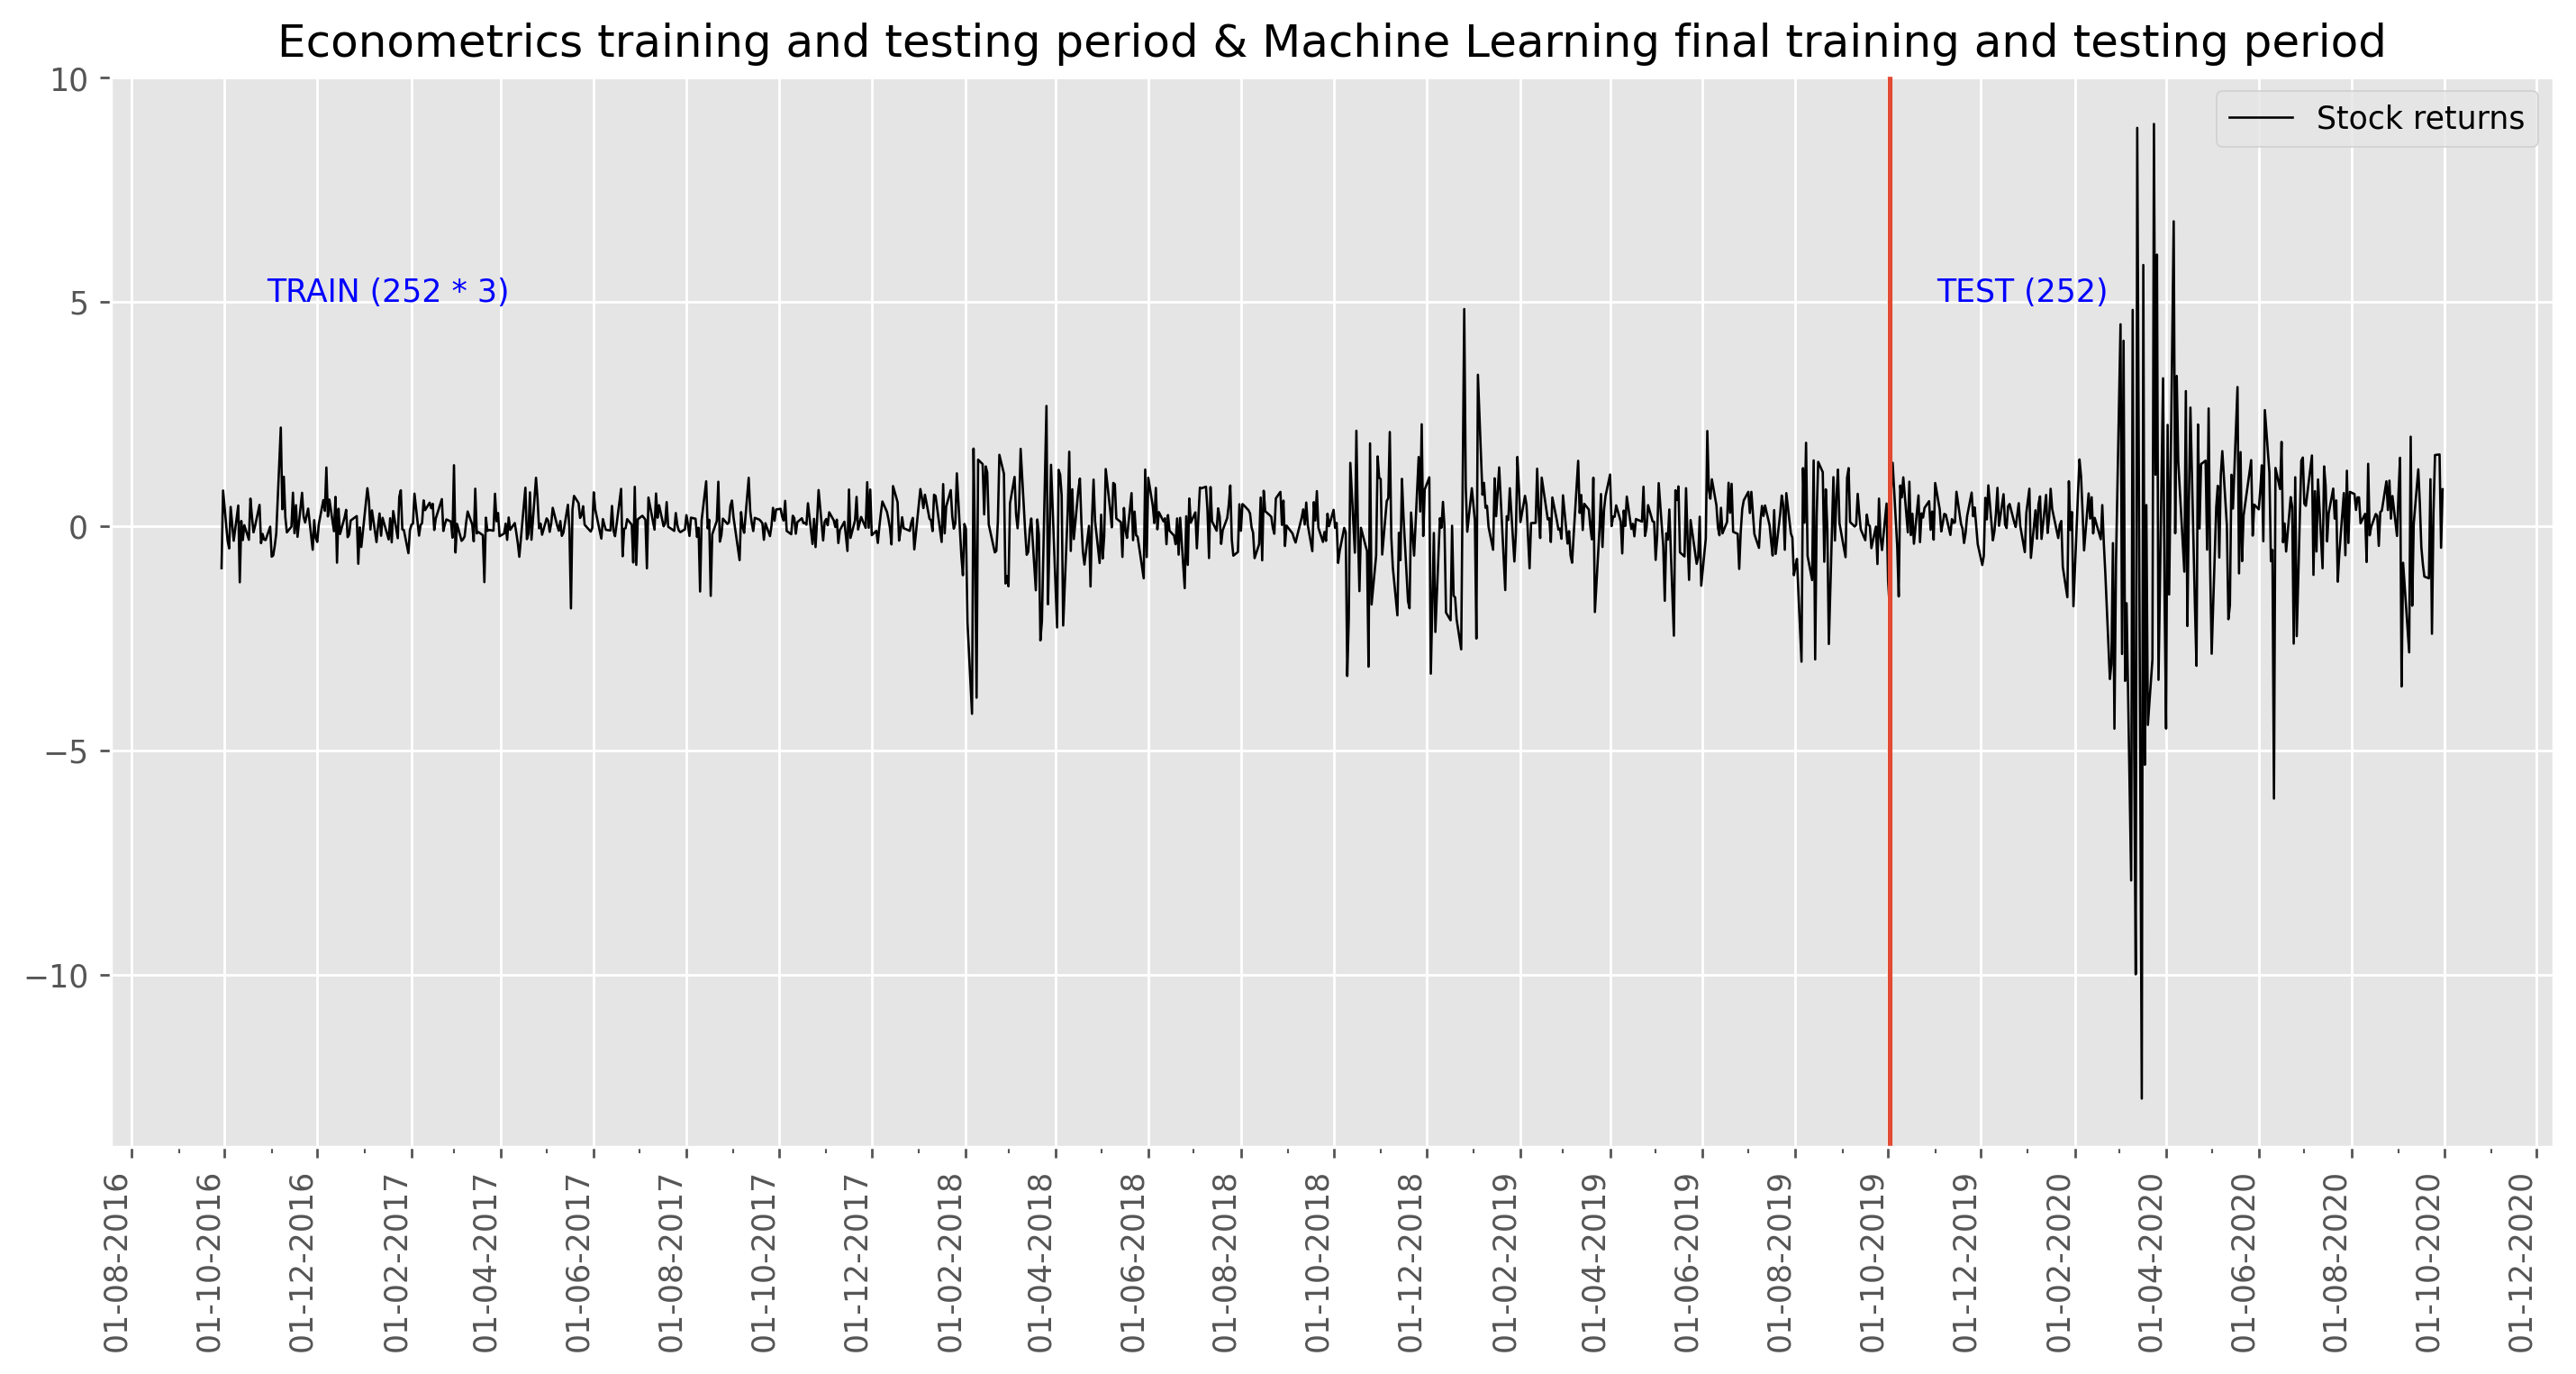

In [35]:
ax = df[["rr"]].iloc[-(252*3+252):].plot(color='black', label="stock_returns", linewidth=0.75, figsize=(14,7))
plt.legend(["Stock returns"], fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()
plt.title("Econometrics training and testing period & Machine Learning final training and testing period")
plt.axvline(x="2019-10-02")
plt.text("2019-11-02",5,'TEST (252)',rotation=0, fontsize=10, color="blue")
plt.text("2016-10-29",5,'TRAIN (252 * 3)',rotation=0, fontsize=10, color="blue")
plt.xlabel("")
plt.xticks(rotation=90)
plt.show()

In [36]:
stats = df[["rr"]].iloc[-(252*3+252):-252].describe()
stats.loc["jarque_bera"] = df[["rr"]].iloc[-(252*3+252):-252].apply(lambda x: scipy.stats.jarque_bera(x)[1])
stats.loc['skew'] = df[["rr"]].iloc[-(252*3+252):-252].skew().tolist()
stats.loc['kurt'] = df[["rr"]].iloc[-(252*3+252):-252].kurtosis().tolist()

stats1 = df[["rr"]].iloc[-252:].describe()
stats1.loc["jarque_bera"] = df[["rr"]].iloc[-252:].apply(lambda x: scipy.stats.jarque_bera(x)[1])
stats1.loc['skew'] = df[["rr"]].iloc[-252:].skew().tolist()
stats1.loc['kurt'] = df[["rr"]].iloc[-252:].kurtosis().tolist()

stats2 = df[["rr"]].iloc[-(252*3+252):].describe()
stats2.loc["jarque_bera"] = df[["rr"]].iloc[-(252*3+252):].apply(lambda x: scipy.stats.jarque_bera(x)[1])
stats2.loc['skew'] = df[["rr"]].iloc[-(252*3+252):].skew().tolist()
stats2.loc['kurt'] = df[["rr"]].iloc[-(252*3+252):].kurtosis().tolist()

stats = pd.concat([stats, stats1, stats2], axis=1)
stats.columns = ["Training", "Testing", "Training & Testing"]
stats = stats.T
stats

,count,mean,std,min,25%,50%,75%,max,jarque_bera,skew,kurt
Training,756.0,0.040097,0.805931,-4.184256,-0.242098,0.058973,0.443732,4.840324,0.0,-0.648893,5.512918
Testing,252.0,0.053309,2.146715,-12.765214,-0.467830,0.232585,0.823434,8.968316,0.0,-0.906924,9.552796
Training & Testing,1008.0,0.043400,1.278937,-12.765214,-0.289501,0.075744,0.516159,8.968316,0.0,-1.170274,22.430201


### Machine Learning training, validation and testing periods

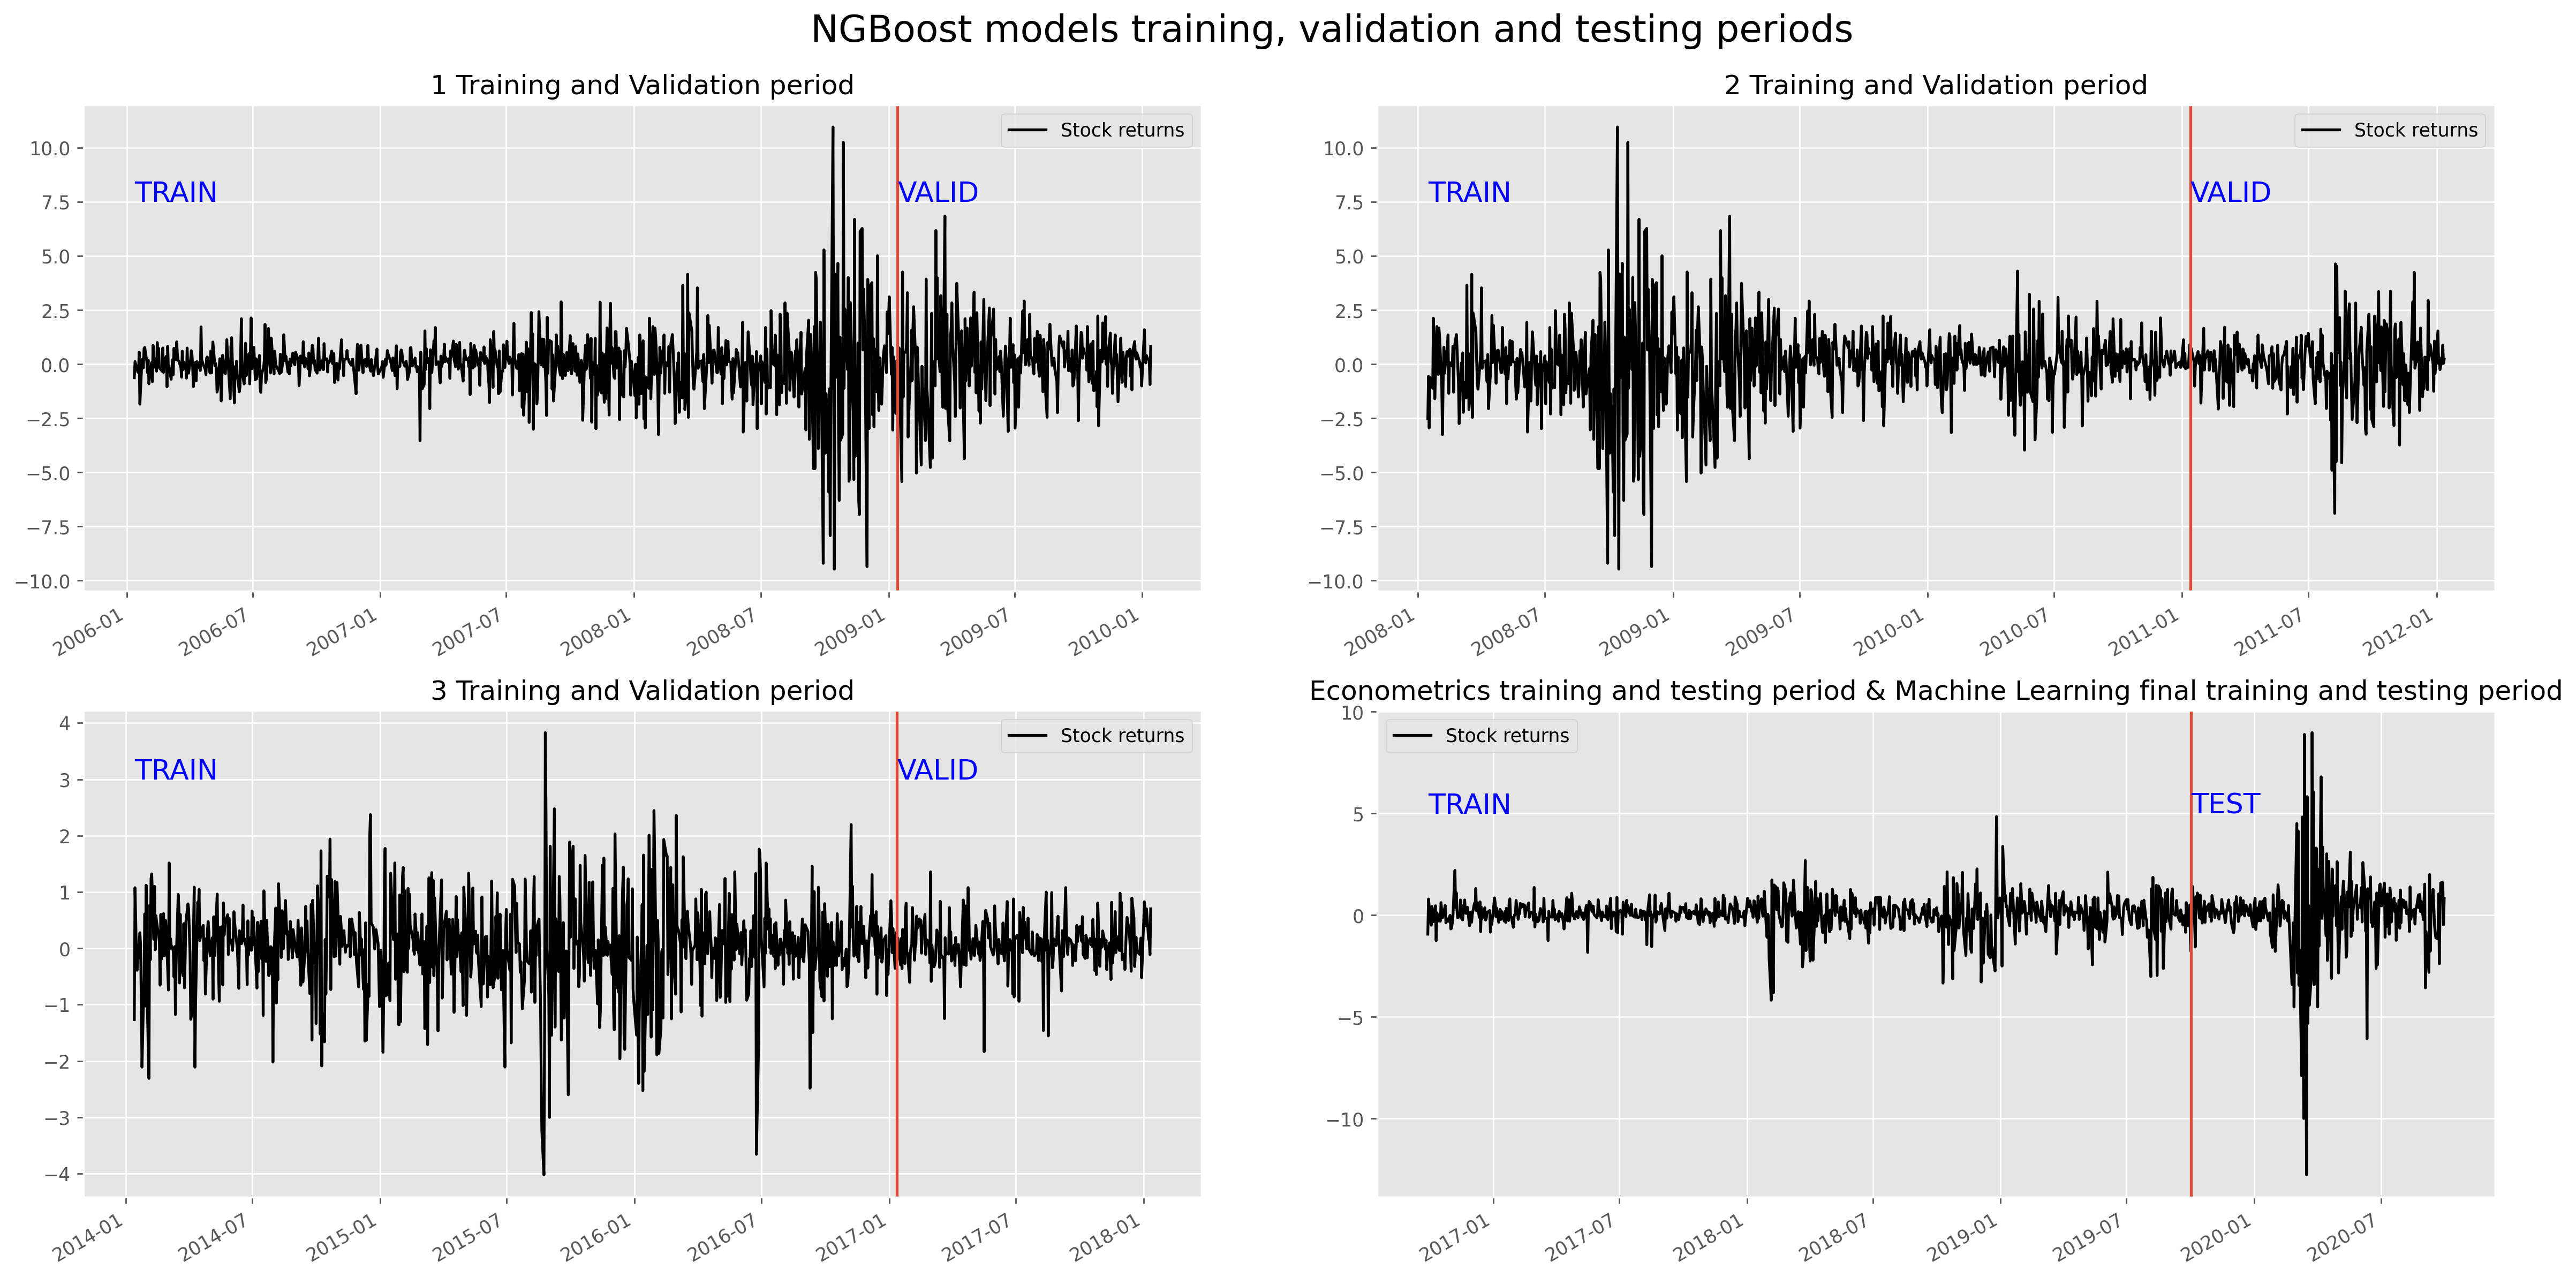

In [37]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
fig.suptitle('NGBoost models training, validation and testing periods', fontsize=20, )

start = '2006-01-12'
df_tmp = df[["rr"]].loc[start:].head(252*4).copy()
end = df_tmp[["rr"]].iloc[-253:].index[0]
test_start = df_tmp[["rr"]].iloc[-252:].index[0]
test_end = df_tmp[["rr"]].iloc[-1:].index[0]
df_tmp.plot(color='black', label="stock_returns", ax=ax1)
ax1.legend(["Stock returns"])
ax1.axvline(x=test_start)
ax1.text(test_start,7.5,'VALID',rotation=0, fontsize=15, color="blue")
ax1.text(df_tmp[["rr"]].iloc[-(252*3+252):].index[0],7.5,'TRAIN',rotation=0, fontsize=15, color="blue")
ax1.set_title("1 Training and Validation period")
ax1.set_xlabel("")

start = '2008-01-15'
df_tmp = df[["rr"]].loc[start:].head(252*4).copy()
end = df_tmp[["rr"]].iloc[-253:].index[0]
test_start = df_tmp[["rr"]].iloc[-252:].index[0]
test_end = df_tmp[["rr"]].iloc[-1:].index[0]
df_tmp.plot(color='black', label="stock_returns", ax=ax2)
ax2.legend(["Stock returns"])
ax2.axvline(x=test_start)
ax2.text(test_start,7.5,'VALID',rotation=0, fontsize=15, color="blue")
ax2.text(df_tmp[["rr"]].iloc[-(252*3+252):].index[0],7.5,'TRAIN',rotation=0, fontsize=15, color="blue")
ax2.set_title("2 Training and Validation period")
ax2.set_xlabel("")

start = '2014-01-13'
df_tmp = df[["rr"]].loc[start:].head(252*4).copy()
end = df_tmp[["rr"]].iloc[-253:].index[0]
test_start = df_tmp[["rr"]].iloc[-252:].index[0]
test_end = df_tmp[["rr"]].iloc[-1:].index[0]
df_tmp.plot(color='black', label="stock_returns", ax=ax3)
ax3.legend(["Stock returns"])
ax3.axvline(x=test_start)
ax3.text(test_start,3,'VALID',rotation=0, fontsize=15, color="blue")
ax3.text(df_tmp[["rr"]].iloc[-(252*3+252):].index[0],3,'TRAIN',rotation=0, fontsize=15, color="blue")
ax3.set_title("3 Training and Validation period")
ax3.set_xlabel("")

df[["rr"]].iloc[-(252*3+252):].plot(color='black', label="stock_returns", ax=ax4)
ax4.legend(["Stock returns"], fontsize=10)
ax4.axvline(x="2019-10-02")
ax4.text("2019-10-02",5,'TEST',rotation=0, fontsize=15, color="blue")
ax4.text("2016-09-29",5,'TRAIN',rotation=0, fontsize=15, color="blue")
ax4.set_xlabel("")
ax4.set_title("Econometrics training and testing period & Machine Learning final training and testing period")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [38]:
for start, j in zip(["2006-01-12", "2008-01-15", "2014-01-13"], [1,2,3]):
    df_tmp = df[["rr"]].loc[start:].head(252*4).copy()
    
    stats = df_tmp[["rr"]].iloc[-(252*3+252):-252].describe()
    stats.loc["jarque_bera"] = df_tmp[["rr"]].iloc[-(252*3+252):-252].apply(lambda x: scipy.stats.jarque_bera(x)[1])
    stats.loc['skew'] = df_tmp[["rr"]].iloc[-(252*3+252):-252].skew().tolist()
    stats.loc['kurt'] = df_tmp[["rr"]].iloc[-(252*3+252):-252].kurtosis().tolist()

    stats1 = df_tmp[["rr"]].iloc[-252:].describe()
    stats1.loc["jarque_bera"] = df_tmp[["rr"]].iloc[-252:].apply(lambda x: scipy.stats.jarque_bera(x)[1])
    stats1.loc['skew'] = df_tmp[["rr"]].iloc[-252:].skew().tolist()
    stats1.loc['kurt'] = df_tmp[["rr"]].iloc[-252:].kurtosis().tolist()

    stats2 = df_tmp[["rr"]].describe()
    stats2.loc["jarque_bera"] = df_tmp[["rr"]].apply(lambda x: scipy.stats.jarque_bera(x)[1])
    stats2.loc['skew'] = df_tmp[["rr"]].skew().tolist()
    stats2.loc['kurt'] = df_tmp[["rr"]].kurtosis().tolist()

    stats = pd.concat([stats, stats1, stats2], axis=1)
    stats.columns = ["Training", "Validation", "Training & Validation"]
    stats = stats.T
    print(f"{j} Training and Validation period")
    display(stats)
    print("\n")

1 Training and Validation period


,count,mean,std,min,25%,50%,75%,max,jarque_bera,skew,kurt
Training,756.0,-0.052260,1.656138,-9.469514,-0.535077,0.075392,0.570354,10.957196,0.000000e+00,-0.265110,10.553457
Validation,252.0,0.108415,1.686463,-5.426198,-0.756607,0.230007,0.973191,6.836638,6.301182e-11,-0.083487,2.175261
Training & Validation,1008.0,-0.012091,1.664386,-9.469514,-0.560251,0.090835,0.631442,10.957196,0.000000e+00,-0.215290,8.310171




2 Training and Validation period


,count,mean,std,min,25%,50%,75%,max,jarque_bera,skew,kurt
Training,756.0,-0.012765,1.906618,-9.469514,-0.812647,0.083978,0.771427,10.957196,0.0,-0.173179,5.843177
Validation,252.0,0.002933,1.472303,-6.895833,-0.690554,0.105310,0.742640,4.631738,0.0,-0.520800,2.930692
Training & Validation,1008.0,-0.008841,1.807164,-9.469514,-0.783199,0.090900,0.765230,10.957196,0.0,-0.224364,5.843615




3 Training and Validation period


,count,mean,std,min,25%,50%,75%,max,jarque_bera,skew,kurt
Training,756.0,0.027919,0.845847,-4.021142,-0.355247,0.029361,0.475622,3.829129,0.0,-0.357638,2.276637
Validation,252.0,0.077716,0.423489,-1.834551,-0.120857,0.058973,0.259426,1.358118,0.0,-0.480933,2.931045
Training & Validation,1008.0,0.040368,0.762616,-4.021142,-0.270616,0.042031,0.443047,3.829129,0.0,-0.419945,3.141295


###  Testing occurrence of ARCH effects (ARCH-LM test) and variance grouping (Box-Ljung test) for the undertaken rates of return during final  training and testing period

In [53]:
df_tmp = df[["rr"]].iloc[-(252*3+252):]
residuals = df_tmp.rr - np.mean(df_tmp.rr)

ARCH-LM test with Null hypothesis: no ARCH effects

In [54]:
for i in range(1,int(np.ceil(np.log(4*252))+1)):
    _, pval, _, _ = diagnostic.het_arch(residuals, i)
    print(f"p-value for Lagrange multiplier test (lags {i})", pval)

p-value for Lagrange multiplier test (lags 1) 1.1602432415779678e-58
p-value for Lagrange multiplier test (lags 2) 1.0276399083158979e-84
p-value for Lagrange multiplier test (lags 3) 8.248146555744827e-84
p-value for Lagrange multiplier test (lags 4) 1.1293532679272521e-82
p-value for Lagrange multiplier test (lags 5) 2.4490081503499596e-85
p-value for Lagrange multiplier test (lags 6) 2.258603967741478e-89
p-value for Lagrange multiplier test (lags 7) 1.5523388777104741e-89


Rates of return (residuals) are characterized by conditional heteroscedasticity and are autocorrelated in the square.

H-

In [15]:
np.log(950)

6.856461984594587

Date
2016-09-29   -0.979902
2016-09-30    0.750233
2016-10-03   -0.369999
2016-10-04   -0.540190
2016-10-05    0.385349
                ...   
2020-09-24    0.254895
2020-09-25    1.541648
2020-09-28    1.554815
2020-09-29   -0.525825
2020-09-30    0.778583
Name: rr, Length: 1008, dtype: float64